# Guidelines

1. **Preprocessing**
    1. Imports
    1. Opening the Data
    1. Verifying Consistency
    1. Feature Scaling
    1. Deleting Vars with too many NaNs
    1. Filling NaNs
    1. Deleting Vars with too many Categories
    1. Feature Selection with Decision Trees
1. **Modelling**
    1. Imports
    1. Train Test Split
    1. Evaluating Models' Performances (ROC-AUC)
1. **Best Model Optimization (Gradient Boosting)**
    1. Separate Optimization
    1. Global Optimization
    1. Final Model's ROC-AUC

## Results

In the end, for the training set we will have ROC-AUCs:

- **Churn**: 0.73202
- **Upselling**: 0.86373
- **Appetency**: 0.82624


$\Rightarrow$ **Average**: 0.80733

### Short Notes

The targets are very sparse, which causes many problems, since putting everything to zeros should be good enough to get very high levels of accuracy.


To mitigate this effect, besides using ROC-AUC, FPR and TPR criteria, we could resample the positive values on the targets. However, this has not been proven very effective, neither **Subsampling** the negative values nor using **SMOTE** to supersample the positive values worked very well.


Another item to try in a later attempt is to calculate the **mutual info scores** (analogous to Pearson Correlations, but for classes), in order to get how much information even the variables with many NaNs carry. In this notebook, I deliberately deleted variables with too many NaNs instead.

## Main Files

- Notebooks:
    - `Churn Training.ipynb`
    - `Churn Testing.ipynb`
- Python Scripts:
    - `churn_hekima_v2.py` - training
    - `hekima_small_test.py` - testing

# 1. Preprocessing

1. Imports
1. Opening the Data
1. Verifying Consistency
1. Feature Scaling
1. Deleting Vars with too many NaNs
1. Filling NaNs
1. Deleting Vars with too many Categories
1. Feature Selection with Decision Trees

## 1.1 Imports

In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.ensemble import RandomForestClassifier

## 1.2 Opening the Training Data

### Independent Variables

In [ ]:
df = pd.read_csv('orange_small_train.data', sep = '\t')
df_num = df.iloc[:, :-40]
df_cat = df.iloc[:, -40:]

### Targets

In [2]:
df_churn = pd.read_csv('orange_small_train_churn.labels', 
                       header = None, names = ['churn'])
df_upselling = pd.read_csv('orange_small_train_upselling.labels', 
                           header = None, names = ['upselling'])
df_appetency = pd.read_csv('orange_small_train_appetency.labels', 
                           header = None, names = ['appetency'])
df_targets = pd.concat([df_churn, df_upselling, df_appetency],
                       axis = 1)

## 1.3 Verifying Consistency

#### Are the Number Variables really numbers?

In [3]:
sum_check = list(df_num.sum().values)
sum_check = [float(i) for i in sum_check]
num_check = sum([type(sum_check[i]) == float 
                 for i in range(0, len(sum_check))])

#### The answer is yes apparently, since there are 190 float numbers in the check variable

In [4]:
print('The number of valid numerical variables is:')
print(f'{num_check} out of {len(sum_check)}')

The number of valid numerical variables is:
190 out of 190


#### Are the categorical variables really categorical?

In [5]:
def check_column_cat(df_col):
    """
    Checks if all the elements in a categorical column 
    are indeed categorical.
    """
    
    str_count = 0
    for i in range(0, df_col.shape[0]):
        if type(df_col.index[i]) == str:
            str_count += 1
            
    return str_count == df_col.shape[0]

#### Looping on all the columns

In [7]:
col_checks = []
for col in df_cat.columns:
    catty = pd.DataFrame(df_cat[col])
    if int(catty.isnull().sum()) == catty.shape[0]:
        continue
    cat = catty.groupby(col).size()
    col_checks.append(check_column_cat(cat))
    
cat_check = sum(col_checks)
print('The number of valid categorical variables is:')
print(f'{cat_check} out of {len(col_checks)}')

The number of valid categorical variables is:
38 out of 38


#### Correcting the data types on the dataframe

In [8]:
df_num = df_num.astype('float')
df_cat = df_cat.astype('category')
df_all = pd.concat([df_num, df_cat], axis = 1)

#### Correcting the data types on the targets

In [10]:
df_churn = df_churn.astype('category')
df_upselling = df_upselling.astype('category')
df_appetency = df_appetency.astype('category')
df_targets = df_targets.astype('category')

## 1.4 Feature Scaling

#### Necessary, otherwise some features will inevitably have more importance than others.

In [9]:
df_num = (df_num - df_num.mean()) / df_num.std()

mean, std = pd.DataFrame(df_num.mean()), pd.DataFrame(df_num.std())
mean.to_csv('train_mean.csv')
std.to_csv('train_std.csv')

## 1.5 Deleting Vars with Too Many NaNs

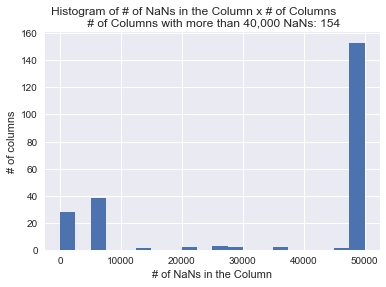

In [11]:
nans_per_col = df_all.isnull().sum()
num_40k = nans_per_col[nans_per_col >= 40000].shape[0]

nans_per_col.hist(bins = 20)
plt.xlabel('# of NaNs in the Column')
plt.ylabel('# of columns')
plt.title(f'Histogram of # of NaNs in the Column x # of Columns \
          \n # of Columns with more than 40,000 NaNs: {num_40k}')
plt.show()
plt.close()

In [13]:
def delete_useless(df, max_na):
    """
    Deletes variables with more than 'max_na' NaNs.
    """
    
    cols = df.columns
    for col in cols:    
        if df[col].isnull().sum() >= max_na:
            del df[col]

#### Deleting Variables with more than 40,000 NaNs

In [14]:
delete_useless(df_num, 40000)
delete_useless(df_cat, 40000)

## 1.6 Filling NaNs

In [16]:
df_num = df_num.fillna(df_num.mean())

#### Running the following twice will give an error due to adding the same category twice.

In [17]:
for col in df_cat.columns:
    df_cat[col] = df_cat[col].cat.add_categories('missing')
    df_cat[col] = df_cat[col].fillna('missing')

## 1.7 Deleting Vars with Too Many Categories

#### Grouping the Categories of each column.

In [18]:
num_cats = []
for col in df_cat.columns:
    
    df_col = pd.DataFrame(df_cat[col])
    df_col = df_col.groupby(col).size()
    num_cats.append([col, df_col.index.shape[0]])

num_cats_num = [item[1] for item in num_cats]

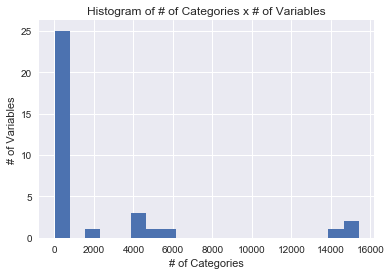

In [20]:
plt.hist(num_cats_num, bins = 20)
plt.xlabel('# of Categories')
plt.ylabel('# of Variables')
plt.title('Histogram of # of Categories x # of Variables')
plt.show()
plt.close()

#### Given that most of the categorical variables have at most 2,000 categories, let's get rid of the excessive ones.

In [21]:
cat_del = [] # categories to delete
for item in num_cats:
    if item[1] > 2000:
        cat_del.append(item[0])
        
for cat in cat_del:
    del df_cat[cat]
    
df_all = pd.concat([df_num, df_cat], axis = 1)

# 1.8 Feature Selection with Decision Trees

#### Importance Ordering based on a Random Forest Classifier.

In [22]:
def get_importances(features, targets):
    """
    Returns the feature importances and orders them.
    """
    
    # Running the Tree
    clf_tree = RandomForestClassifier(n_estimators = 500,
                                      criterion = 'entropy',
                                      n_jobs = 5, 
                                      random_state = 42)
    clf_tree.fit(features, targets.values.ravel())
    importances = clf_tree.feature_importances_
    
    # Ordering the Importance of the Variables
    variables = np.array(features.columns)
    indices = np.argsort(importances)[: : -1]
    importances = importances[indices]
    variables = variables[indices]
    
    return variables, importances

#### Dummy Variables Encoding.

Probably can delete one of the columns for each variable (dummy variable trap). But this will be done naturally when we get the most important features from the Random Forest.

In [23]:
df_dummies = pd.get_dummies(df_all)

In [24]:
dict_targets = {'Churn' : df_churn,
                'Upselling' : df_upselling,
                'Appetency' : df_appetency}

In [25]:
dict_importances = {k : get_importances(df_dummies, v) 
                    for k, v in dict_targets.items()}

In [26]:
def sum_importances(variables, importances):
    """
    Sums the importances up to the k-th variable.
    Cumulative Importance.
    """
    
    sum_importances = []
    for i in range(importances.shape[0]):
        sum_importance = importances[:(i + 1)].sum()
        sum_importances.append([variables[i], sum_importance])

    return sum_importances

#### Cumulative Sum of the Importances

In [27]:
dict_sum_importances = {k : sum_importances(v[0], v[1])
                        for k, v in dict_importances.items()}

In [28]:
def thresh_vars(features, sum_importance_list, threshold):
    """
    Thresholds the most important features.
    """
    
    thresh_vars = []
    for item in sum_importance_list:
        if item[1] <= threshold:
            thresh_vars.append(item[0])
            
    df = features.loc[:, thresh_vars]
    
    return df

#### 99% Threshold. Many features seem to not help too much (see graph below).

In [29]:
dict_thresh = {k : thresh_vars(df_dummies, v, 0.99) 
              for k, v in dict_sum_importances.items()}

#### Saving the training dataset for later use during testing.

In [30]:
for k, v in dict_thresh.items():
    v.to_csv(f'train_thresh_{k}.csv')

#### Saving the Columns of the Filtered Variables (for the testing later).

In [31]:
columns_thresh = {k : list(v.columns)
                  for k, v in dict_thresh.items()}
with open('variables.json', 'w') as file:
    json.dump(columns_thresh, file)

#### Reopening the Columns of the Filtered Variables.

In [32]:
with open('variables.json', 'r') as file:
    columns_thresh = json.load(file)

#### Importance Sum x Amount of Variables Graph

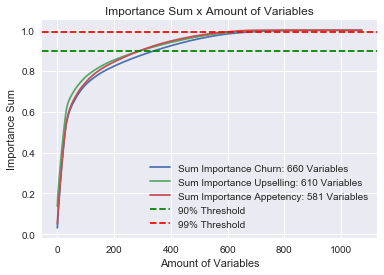

In [33]:
dict_sum_imp = {k : [item[1] for item in v]
                for k, v in dict_sum_importances.items()}

for k, v in dict_sum_imp.items():
    plt.plot(np.linspace(1, len(v), len(v)), v,
             label = f'Sum Importance {k}: {dict_thresh[k].shape[1]} Variables')
    
plt.axhline(0.9, color = 'green', label = '90% Threshold', ls = '--')
plt.axhline(0.99, color = 'red', label = '99% Threshold', ls = '--')
plt.xlabel('Amount of Variables')
plt.ylabel('Importance Sum')
plt.title('Importance Sum x Amount of Variables')
plt.legend()
plt.show()
plt.close()

# 2. Modelling

1. Imports
1. Train Test Split
1. Evaluating Models' Performances (ROC-AUC)
1. FPR, TPR, ROC & AUC

## 2.1 Imports

The Random Forest Import is in the Preprocessing part.

In [34]:
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

## 2.2 Train-Test Split

In [35]:
test_size = 0.1
dict_split = {}
for k, v in dict_thresh.items():
    X_train, X_test, y_train, y_test = train_test_split(dict_thresh[k], 
                                                        dict_targets[k],
                                                        test_size = test_size,
                                                        random_state = 42)
    dict_split[k] = [X_train, X_test, 
                     y_train.values.ravel(), y_test.values.ravel()]

## 2.3 Evaluating Models' Performances

In [36]:
def k_fold_val(clf, X, y, n_cv, score_type):
    """
    k-Fold Crossvalidation.
    
    Returns the Mean.
    """
    kv_score = cross_val_score(clf, 
                               X, y,
                               cv = n_cv,
                               scoring = score_type)
    
    return kv_score.mean()

In [37]:
def cross_val_all(clf, dict_Xy, n_cv, score_type):
    """
    Runs k-Fold Cross Validation on all 3 targets.
    """
    
    kv_all = {}
    for k, v in dict_Xy.items():
        kv_all[k] = k_fold_val(clf, 
                               v[0], v[2],
                               n_cv, score_type)
        
    return kv_all

#### Dict with all the classifiers:

For the **NN**, I took a guess for the hidden layers: the number of neurons in each hidden layer is about $= \frac{number \ of \ variables}{2} \approx 300$. 


Avoid using too many estimators for the **Tree Classifiers**, they can take quite long to get optimized.

In [38]:
clfs = {'RF' : RandomForestClassifier(n_estimators = 200,
                                      random_state = 42,
                                      n_jobs = 5),
        'LR' : LogisticRegression(solver = 'lbfgs'),
        'GB' : GradientBoostingClassifier(n_estimators = 200, 
                                          learning_rate = 0.1, 
                                          random_state = 42),
        'DT' : DecisionTreeClassifier(),
        'GNB' : GaussianNB(),
        'SVM' : SVC(gamma = 'auto'),
        'ADA' : AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3),
                                   algorithm="SAMME",
                                   n_estimators = 200),
        'NN' : MLPClassifier(solver = 'adam', max_iter = 5000, 
                             hidden_layer_sizes = (300, 300, 300, 300))}

#### Each Cross Validation is effectively making $3 n_{cv}$ fits and validations.

In [39]:
kv_scores_auc = {}
n_cv, score_func = 5, 'roc_auc'

#### Only calling them separetely to avoid having to wait too much...

The **SVM**, for example, takes about 1.5h to run one iteration of CV. Yes, I waited approximately 3 x 5 = 15h for the SVM... and all this to get mediocre 0.5 AUCs...

In [ ]:
kv_scores_auc['RF'] = cross_val_all(clfs['RF'], dict_split, n_cv, score_func)
kv_scores_auc['LR'] = cross_val_all(clfs['LR'], dict_split, n_cv, score_func)
kv_scores_auc['GB'] = cross_val_all(clfs['GB'], dict_split, n_cv, score_func)
kv_scores_auc['GNB'] = cross_val_all(clfs['GNB'], dict_split, n_cv, score_func)
kv_scores_auc['SVM'] = cross_val_all(clfs['SVM'], dict_split, n_cv, score_func)
kv_scores_auc['ADA'] = cross_val_all(clfs['ADA'], dict_split, n_cv, score_func)
kv_scores_auc['NN'] = cross_val_all(clfs['NN'], dict_split, n_cv, score_func)

#### Algorithm Ranking for Each Target

In [40]:
def sort_scores(scores):
    """
    Sorts kv_scores in descending order.
    """

    c_full, u_full, a_full = [], [], []
    for clf_k, clf_v in kv_scores_auc.items():
        
        for k, v in clf_v.items():
            if k == 'Churn':
                c = [clf_k, v]
            elif k == 'Upselling':
                u = [clf_k, v]
            elif k == 'Appetency':
                a = [clf_k, v]
                
        c_full.append(c)
        u_full.append(u)
        a_full.append(a)
        
    c_df = pd.DataFrame(c_full, columns = ['Algorithm', 'kv_score_auc'])
    u_df = pd.DataFrame(u_full, columns = ['Algorithm', 'kv_score_auc'])
    a_df = pd.DataFrame(a_full, columns = ['Algorithm', 'kv_score_auc'])
    
    ranking = {'Churn' : c_df.sort_values(by = 'kv_score_auc', 
                                          ascending = False),
               'Upselling' : u_df.sort_values(by = 'kv_score_auc', 
                                              ascending = False),
               'Appetency' : a_df.sort_values(by = 'kv_score_auc', 
                                              ascending = False)}
               
    return ranking

In [ ]:
ranking = sort_scores(kv_scores_auc)

#### Saving the `kv_scores_auc` to avoid having to run it again.

In [ ]:
ranking_dict = {'Churn' : ranking['Churn'].values.tolist(), 
                'Upselling' : ranking['Upselling'].values.tolist(),
                'Appetency' : ranking['Appetency'].values.tolist()}
with open('kv_scores_auc_ranked.json', 'w') as file:
    json.dump(ranking_dict, file)

#### Reopening it.

In [42]:
with open('kv_scores_auc_ranked.json', 'r') as file:
    ranking_json = json.load(file)
    
ranking_json = {k: pd.DataFrame(v, columns = ['Algorithm', 'kv_score_auc']) 
                for k, v in ranking_json.items()}

#### Ranking Plot

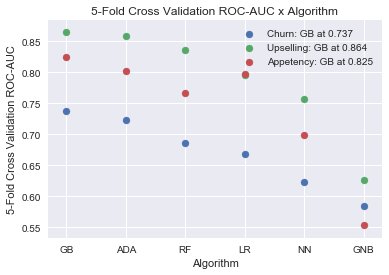

In [43]:
for k, v in ranking_json.items():
    winner_algo = v["Algorithm"].iloc[0]
    winner_score = round(v["kv_score_auc"].iloc[0], 3)
    plt.scatter(v['Algorithm'], v['kv_score_auc'],
                label = f'{k}: {winner_algo} at {winner_score}')  
plt.xlabel('Algorithm')
plt.ylabel(f'{n_cv}-Fold Cross Validation ROC-AUC')
plt.title(f'{n_cv}-Fold Cross Validation ROC-AUC x Algorithm')
plt.legend()
plt.show()
plt.close()

# 3. Best Algorithm Optimization

1. Separate Optimization
1. Global Optimization
1. Final Model's ROC-AUC

From the graph in section 2.3, we can see that the best choice is **Gradient Boosting**. Though, perhaps, with some more optimization Neural Networks could also be a contender.


This is mostly going to be greedy optimization, i.e., we will fix certain parameters and then look for an optimal dependent one. The computational cost of doing a full-scale optimization is too high.


Later, once we have somewhat optimized parameters, we can run a complete Grid Search with more restricted variables.

## 3.1 Separate Optimization

In [44]:
clf_gb = GradientBoostingClassifier(n_estimators = 100, 
                                    learning_rate = 0.1, 
                                    random_state = 42)

This just for reference, the grid search will be taken separetely. If we wanted to do search them all, it would be approximately: $n_{targets} \cdot n_{cv} \cdot 4 \cdot 10 \cdot 6 \cdot 8 \cdot 4 \cdot 4 \approx 280,000$ possible combinations.


If we do it separetely:
$n_{targets} \cdot n_{cv} \cdot (4 + 10 + 6 + 8 + 4 + 4) \approx 330$ possible combinations.

In [45]:
grid_separate = {
                 'n_estimators' : {'n_estimators' : 
                                   [100, 200, 300, 400, 500]},
                 'max_features' : {'max_features' : 
                                   range(20, 41, 2)},
                 'min_samples_split' : {'min_samples_split' : 
                                        range(100, 401, 50)},
                 'min_samples_leaf' : {'min_samples_leaf' : 
                                       range(20, 60, 5)},
                 'subsample' : {'subsample' : 
                                [0.7, 0.8, 0.9, 1]},
                 'learning_rate' : {'learning_rate' : 
                                    [0.01, 0.05, 0.1, 0.5]},
                }

#### Separate `GridSearchCV` for each target, for each parameter.

In [ ]:
CV_gb = {}
for k_target, _ in dict_split.items():
    CV_gb[k_target] = {}
    for k, v in grid_separate.items():
        CV_gb[k_target][k] = GridSearchCV(estimator = clf_gb,
                                param_grid = v,
                                cv = 3,
                                scoring = 'roc_auc')

In [ ]:
def get_best_param(cv_clf, dict_Xy, param):
    """
    Gets the best values for a certain parameter, for each target.
    """
    
    best = {}
    for k, v in dict_Xy.items():
        
        tic = time.time()
        cv_clf[k][param].fit(v[0], v[2])
        tac = time.time()

        best[k] = cv_clf[k][param].best_params_[param]
        
        timey = round((tac - tic) / 60, 2)
        print(f'Grid Search on {k} for the {param}: {timey} minutes.') 
        
    return best

#### Should take a long while... 3h...

In [ ]:
best_params_sep = {k : get_best_param(CV_gb, dict_split, k)
                   for k, _ in grid_separate.items()}

#### Reshaping and saving

In [ ]:
best_sep = {}
for k, _ in dict_split.items():
    best_p = {}
    for k_params, _ in grid_separate.items():
        best_p[k_params] = best_params_sep[k_params][k]
        
    best_sep[k] = best_p

In [ ]:
with open('best_params_sep_new.json', 'w') as file:
    json.dump(best_sep, file) 

#### Reopening it

In [ ]:
with open('best_params_sep_new.json', 'r') as file:
    best_sep = json.load(file)

## 3. 2 Global Optimization

In [48]:
clf_gb_global = {}
for k, _ in dict_split.items():
    clf_gb_global[k] = GradientBoostingClassifier(n_estimators = 100, 
                                                  learning_rate = 0.1, 
                                                  random_state = 42) 


This just for reference, the grid search will be taken separetely.
The `min_samples_split`, `min_samples_leaf` and `subsample` parameters will be fixed for simplification. Now we have managed to reduce the search space to approximately: $n_{targets} \cdot n_cv \cdot 3 \cdot 3 \cdot 5 = 3^4 \cdot 5 = 405$ possible combinations.

In [ ]:
param_grid_global = {
                     'Churn' : {
                                'n_estimators' : [80, 100, 120, 300, 500],
                                'max_features' : range(35, 37, 1),
                                'min_samples_split' : [150],
                                'min_samples_leaf' : [20],
                                'subsample' : [0.75, 1],
                                'learning_rate' : [0.05, 0.1, 0.15]
                               },
                     'Upselling' : {
                                    'n_estimators' : [80, 100, 120, 300, 500],
                                    'max_features' : [38],
                                    'min_samples_split' : [200],
                                    'min_samples_leaf' : [45],
                                    'subsample' : [1],
                                    'learning_rate' : [0.05, 0.1, 0.15]
                                   }, 
                     'Appetency' : {
                                    'n_estimators' : [80, 100, 120, 300, 500],
                                    'max_features' : [38],
                                    'min_samples_split' : [100],
                                    'min_samples_leaf' : [55],
                                    'subsample' : [1],
                                    'learning_rate' : [0.05, 0.1, 0.15]
                                   }, 
                    }

In [ ]:
CV_gb_global = {}
for k, v in dict_split.items():
    CV_gb_global[k] = GridSearchCV(estimator = clf_gb_global[k],
                                   param_grid = param_grid_global[k],
                                   cv = 3,
                                   scoring = 'roc_auc')

In [ ]:
best_params_global, time_to_opt_global = {}, {}
for k, v in dict_split.items():
    
    tic = time.time()
    CV_gb_global[k].fit(v[0], v[2])
    tac = time.time()
    
    time_to_opt_global[k] = round(((tac - tic) / 60), 2)
    best_params_global[k] = CV_gb_global[k].best_params_
    
    print(f'Time of the Grid Search for {k}: {time_to_opt_global[k]} minutes.')
    print(f'{k}: {best_params_global[k]}')

#### Saving

In [ ]:
with open('best_params_global.json', 'w') as file:
    json.dump(best_params_global, file)

#### Opening

In [ ]:
with open('best_params_global.json', 'r') as file:
    best_params_global = json.load(file)

## 3.3 Final Model's ROC-AUC

In [ ]:
clf_gb_ult = {
              'Churn' : GradientBoostingClassifier(n_estimators = 500, 
                                                   learning_rate = 0.05,
                                                   min_samples_split = 150,
                                                   min_samples_leaf = 20,
                                                   max_features = 35,
                                                   subsample = 0.75,
                                                   random_state = 42),
              'Upselling' : GradientBoostingClassifier(n_estimators = 300, 
                                                       learning_rate = 0.1,
                                                       min_samples_split = 200,
                                                       min_samples_leaf = 45,
                                                       max_features = 38,
                                                       subsample = 1,
                                                       random_state = 42),
              'Appetency' : GradientBoostingClassifier(n_estimators = 300, 
                                                       learning_rate = 0.05,
                                                       min_samples_split = 100,
                                                       min_samples_leaf = 55,
                                                       max_features = 38,
                                                       subsample = 1,
                                                       random_state = 42),
             }

#### Final Score

In [ ]:
n_cv, score_type = 5, 'roc_auc'
kv_score_final = {}
for k, v in clf_gb_ult.items():
    
    kv_score_final[k] = cross_val_score(v, 
                                        dict_thresh[k], 
                                        dict_targets[k].values.ravel(),
                                        cv = n_cv,
                                        scoring = score_type)

In [ ]:
for k, v in kv_score_final.items():
    kv_score_final[k] = round(kv_score_final[k].mean(), 5)
    print(f'Final ROC-AUC Score for the {k} Target: {kv_score_final[k]}')

#### Saving

In [ ]:
with open('performance_train.json', 'w') as file:
    json.dump(kv_score_final, file)

#### Opening

In [51]:
with open('performance_train.json', 'r') as file:
    performance = json.load(file)

In [53]:
for k, v in performance.items():
    print(f'ROC-AUC for the {k} target: {v}')

ROC-AUC for the Churn target: 0.73202
ROC-AUC for the Upselling target: 0.86373
ROC-AUC for the Appetency target: 0.82624
